In [1]:
!pip -q install pandas numpy matplotlib scikit-learn imbalanced-learn scipy joblib pyarrow fastparquet
import os,json,warnings,joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report,confusion_matrix,roc_auc_score,
    RocCurveDisplay,PrecisionRecallDisplay,average_precision_score,
    precision_recall_curve)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.inspection import permutation_importance

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',200)
pd.set_option('display.width',220)
plt.rcParams['figure.figsize']=(9,5)

RANDOM_STATE=42
JSON_PATH="/content/TelecomX_Data.json"
ARTIFACT_DIR="/content/telecomx_artifacts"
os.makedirs(ARTIFACT_DIR,exist_ok=True)
REPORT_PATH="/content/TelecomX_Part2_Report.md"
GOLD_PATH="/content/telecomx_churn_gold.csv" # se genera aquí para trazabilidad

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.4 MB/s eta 0:00:00


In [2]:
def _flatten_records(obj):
    """Devuelve lista de dicts desde JSON en formatos comunes."""
    if isinstance(obj,list):
        return obj
    if isinstance(obj,dict):
        for key in ['data','results','items','records']:
            if key in obj and isinstance(obj[key],list):
                return obj[key]
        return [obj]
    return []

def normalize_colnames(cols):
    """Normaliza nombres: espacios/puntos/guiones → guion_bajo."""
    out=[]
    for c in cols:
        c2=c.strip().replace(' ','_').replace('.','_').replace('-','_')
        out.append(c2)
    return out

# Carga JSON
if not os.path.exists(JSON_PATH):
    raise FileNotFoundError(f"No se encontró {JSON_PATH}. Súbelo a /content.")
with open(JSON_PATH,'r',encoding='utf-8') as f:
    raw=json.load(f)

records=_flatten_records(raw)
if not records:
    raise ValueError("No se pudieron extraer registros del JSON.")

# DataFrame + normalización mínima de columnas
df_raw=pd.json_normalize(records,max_level=1)
df_raw.columns=normalize_colnames(df_raw.columns)

print("Shape df_raw:",df_raw.shape)
display(df_raw.head())

Shape df_raw: (7267, 20)


,customerID,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,internet_OnlineSecurity,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,"{'Monthly': 65.6, 'Total': '593.3'}"
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,"{'Monthly': 59.9, 'Total': '542.4'}"
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,"{'Monthly': 73.9, 'Total': '280.85'}"
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,"{'Monthly': 98.0, 'Total': '1237.85'}"
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,"{'Monthly': 83.9, 'Total': '267.4'}"


In [3]:
# Mapeos de nombres de columnas
RENAME_MAP={'Charges_Monthly':'Charges_Monthly','Charges_Total':'Charges_Total',
            'MonthlyCharges':'Charges_Monthly','TotalCharges':'Charges_Total'}
df=df_raw.copy()
for k,v in list(RENAME_MAP.items()):
    if k in df.columns and v not in df.columns:
        df.rename(columns={k:v},inplace=True)

# Extraer cobros desde la columna-diccionario 'account_Charges'
if 'account_Charges' in df.columns:
    df['Charges_Monthly']=df['account_Charges'].apply(lambda x:x.get('Monthly') if isinstance(x,dict) else None)
    df['Charges_Total']=df['account_Charges'].apply(lambda x:x.get('Total') if isinstance(x,dict) else None)
    df=df.drop(columns=['account_Charges'])

print("Columnas recibidas:",df.columns.tolist())

# Funciones auxiliares de tipificación
def coerce_numeric(series):
    if series.dtype==object:
        series=series.astype(str).str.replace(',','',regex=False).str.strip()
    return pd.to_numeric(series,errors='coerce')

def tidy_binary(series):
    """Estandariza binarios comunes a 0/1."""
    s=series.copy()
    if pd.api.types.is_numeric_dtype(s):
        return s.fillna(0).round().astype(int)
    m={'yes':1,'y':1,'true':1,'1':1,'si':1,'sí':1,
       'no':0,'n':0,'false':0,'0':0}
    return s.astype(str).str.lower().str.strip().map(m).fillna(0).astype(int)

# Tipificación numérica
for col in ['tenure','Charges_Monthly','Charges_Total','SeniorCitizen']:
    if col in df.columns:
        df[col]=coerce_numeric(df[col])

# Binarios 0/1
binary_cols=['Churn','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines',
             'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport',
             'StreamingTV','StreamingMovies','PaperlessBilling']
for col in binary_cols:
    if col in df.columns:
        df[col]=tidy_binary(df[col])

# Categóricos
for col in ['gender','InternetService','Contract','PaymentMethod']:
    if col in df.columns:
        df[col]=df[col].astype('category')

# Imputación (num→mediana, cat→moda)
num_cols_all=df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols_all=df.select_dtypes(include=['object','category']).columns.tolist()
for c in num_cols_all:
    if df[c].isna().any():
        df[c]=df[c].fillna(df[c].median())
for c in cat_cols_all:
    if df[c].isna().any():
        df[c]=df[c].fillna(df[c].mode().iloc[0])

# Consistencia TotalCharges
if {'Charges_Monthly','tenure','Charges_Total'}.issubset(df.columns):
    expected=(df['Charges_Monthly']*df['tenure']).round(2)
    df['TotalCharges_Delta']=(df['Charges_Total']-expected).round(2)

# Duplicados
dup=df.duplicated().sum()
if dup:
    df=df.drop_duplicates()
    print(f"Se eliminaron {dup} duplicados.")

print("Shape df (limpio mínimo):",df.shape)
display(df.head(3))

Columnas recibidas: ['customerID', 'Churn', 'customer_gender', 'customer_SeniorCitizen', 'customer_Partner', 'customer_Dependents', 'customer_tenure', 'phone_PhoneService', 'phone_MultipleLines', 'internet_InternetService', 'internet_OnlineSecurity', 'internet_OnlineBackup', 'internet_DeviceProtection', 'internet_TechSupport', 'internet_StreamingTV', 'internet_StreamingMovies', 'account_Contract', 'account_PaperlessBilling', 'account_PaymentMethod', 'Charges_Monthly', 'Charges_Total']
Shape df (limpio mínimo): (7267, 21)


,customerID,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,internet_OnlineSecurity,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,Charges_Monthly,Charges_Total
0,0002-ORFBO,0,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30
1,0003-MKNFE,0,Male,0,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40
2,0004-TLHLJ,1,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85


In [4]:
df.to_csv(GOLD_PATH,index=False)
print("CSV de trabajo (gold mínimo) →",GOLD_PATH,"| Shape:",df.shape)

CSV de trabajo (gold mínimo) → /content/telecomx_churn_gold.csv | Shape: (7267, 21)


n_features: 19 | num: 4 | cat: 15
Churn rate global: 0.2572
Train: (5450, 19) | Test: (1817, 19)
Churn rate train/test: 0.2572 / 0.257


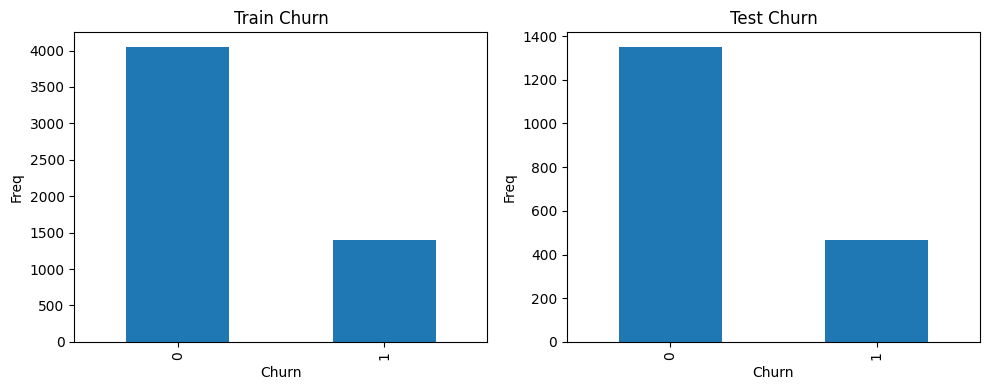

In [5]:
TARGET='Churn'
if TARGET not in df.columns:
    raise ValueError("No se encontró 'Churn' en el dataset procesado.")

ID_COLS=[c for c in ['customerID'] if c in df.columns]
AUX_DROP=[c for c in df.columns if c.lower().startswith('totalcharges_delta')]
DROP_COLS=list(set(ID_COLS+AUX_DROP+[TARGET]))

X=df.drop(columns=DROP_COLS,errors='ignore')
y=df[TARGET].astype(int)

num_cols=X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols=X.select_dtypes(exclude=[np.number]).columns.tolist()

print("n_features:",X.shape[1],"| num:",len(num_cols),"| cat:",len(cat_cols))
print("Churn rate global:",y.mean().round(4))

X_train,X_test,y_train,y_test=train_test_split(
    X,y,test_size=0.25,stratify=y,random_state=RANDOM_STATE
)
print("Train:",X_train.shape,"| Test:",X_test.shape)
print("Churn rate train/test:",y_train.mean().round(4),"/",y_test.mean().round(4))

# Distribución de target
fig,ax=plt.subplots(1,2,figsize=(10,4))
y_train.value_counts().sort_index().plot(kind='bar',ax=ax[0],title='Train Churn')
y_test.value_counts().sort_index().plot(kind='bar',ax=ax[1],title='Test Churn')
for a in ax: a.set_xlabel('Churn'); a.set_ylabel('Freq')
plt.tight_layout(); plt.show()

,feature,point_biserial_corr
1,customer_tenure,-0.344079
3,Charges_Total,-0.194016
2,Charges_Monthly,0.189866
0,customer_SeniorCitizen,0.146733


,feature,cramers_v
12,account_Contract,0.282986
6,internet_OnlineSecurity,0.240453
9,internet_TechSupport,0.237374
5,internet_InternetService,0.222728
7,internet_OnlineBackup,0.202672
8,internet_DeviceProtection,0.194721
13,account_PaperlessBilling,0.186309
14,account_PaymentMethod,0.170530
2,customer_Dependents,0.160968
11,internet_StreamingMovies,0.160141


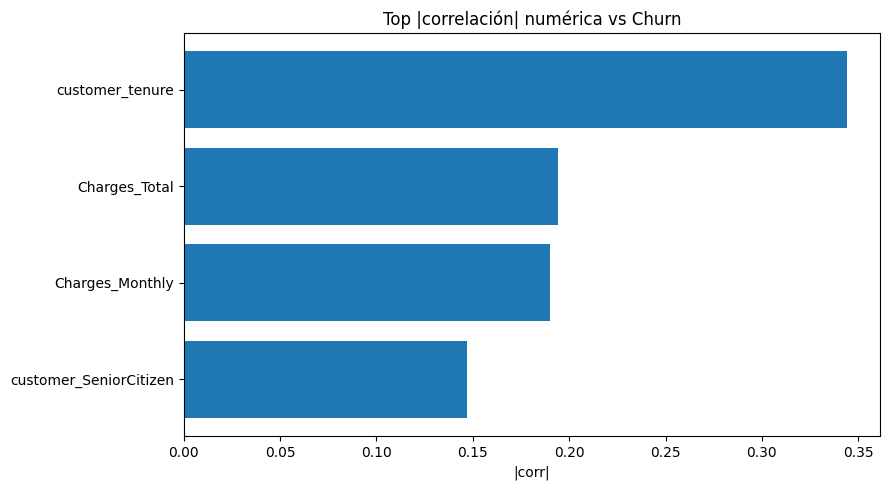

In [6]:
# Correlación punto-biserial (numérico vs target)
num_corr=[]
for c in num_cols:
    if X[c].notna().sum()>2:
        corr=np.corrcoef(X[c].fillna(X[c].median()),y)[0,1]
        num_corr.append((c,corr))
num_corr=pd.DataFrame(num_corr,columns=['feature','point_biserial_corr']).sort_values('point_biserial_corr',key=np.abs,ascending=False)
display(num_corr.head(15))

# Cramér's V (categórico vs target)
def cramers_v(x,y):
    tab=pd.crosstab(x,y)
    chi2,_,_,_=stats.chi2_contingency(tab,correction=False)
    n=tab.values.sum()
    phi2=chi2/n
    r,k=tab.shape
    phi2corr=max(0,phi2-((k-1)*(r-1))/(n-1))
    rcorr=r-((r-1)**2)/(n-1)
    kcorr=k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/max((kcorr-1),(rcorr-1)))

cat_cramers=[]
for c in cat_cols:
    try:
        v=cramers_v(X[c].astype(str),y)
        cat_cramers.append((c,v))
    except Exception:
        pass
cat_cramers=pd.DataFrame(cat_cramers,columns=['feature','cramers_v']).sort_values('cramers_v',ascending=False)
display(cat_cramers.head(15))

# Gráfico top correlaciones numéricas
top_num=num_corr.head(10)
plt.figure()
plt.barh(top_num['feature'][::-1],np.abs(top_num['point_biserial_corr'])[::-1])
plt.title("Top |correlación| numérica vs Churn")
plt.xlabel("|corr|")
plt.tight_layout(); plt.show()

In [7]:
numeric_pipe=Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="median")),
    ("scaler",StandardScaler(with_mean=True,with_std=True))
])

# OneHotEncoder denso (para usar con HistGradientBoosting)
categorical_pipe=Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("ohe",OneHotEncoder(handle_unknown="ignore",sparse_output=False))
])

preprocess=ColumnTransformer(
    transformers=[
        ("num",numeric_pipe,num_cols),
        ("cat",categorical_pipe,cat_cols)
    ],
    remainder="drop"
)

def get_feature_names(preprocess,num_cols,cat_cols):
    ohe=preprocess.named_transformers_["cat"].named_steps["ohe"]
    cat_feature_names=ohe.get_feature_names_out(cat_cols).tolist()
    return list(num_cols)+cat_feature_names

In [8]:
logreg=LogisticRegression(max_iter=500,class_weight="balanced",random_state=RANDOM_STATE)
pipe_lr=Pipeline(steps=[("preprocess",preprocess),("model",logreg)])

cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=RANDOM_STATE)
scoring={"roc_auc":"roc_auc","avg_precision":"average_precision","f1":"f1",
         "precision":"precision","recall":"recall","accuracy":"accuracy"}

cv_res_lr=cross_validate(pipe_lr,X_train,y_train,cv=cv,scoring=scoring,n_jobs=-1,return_train_score=True)
pd.DataFrame(cv_res_lr).describe().T

,count,mean,std,min,25%,50%,75%,max
fit_time,5.0,0.331900,0.089377,0.221379,0.261706,0.366371,0.366753,0.443292
score_time,5.0,0.155945,0.045459,0.093940,0.124888,0.173940,0.180915,0.206041
test_roc_auc,5.0,0.838996,0.014423,0.822683,0.830368,0.838056,0.843111,0.860761
train_roc_auc,5.0,0.843219,0.003932,0.837303,0.842306,0.843439,0.845089,0.847959
test_avg_precision,5.0,0.633438,0.030806,0.593597,0.616156,0.637119,0.644851,0.675464
train_avg_precision,5.0,0.638714,0.008428,0.625945,0.637066,0.638990,0.642757,0.648810
test_f1,5.0,0.613255,0.020270,0.586705,0.599725,0.616000,0.626866,0.636977
train_f1,5.0,0.618620,0.005281,0.612650,0.615593,0.616490,0.623796,0.624571
test_precision,5.0,0.498292,0.010382,0.487696,0.492537,0.492718,0.506579,0.511931
train_precision,5.0,0.501809,0.005658,0.496446,0.496950,0.500000,0.507812,0.507839


In [9]:
hgb=HistGradientBoostingClassifier(random_state=RANDOM_STATE)
pipe_hgb=Pipeline(steps=[("preprocess",preprocess),("model",hgb)])
cv_res_hgb=cross_validate(pipe_hgb,X_train,y_train,cv=cv,scoring=scoring,n_jobs=-1,return_train_score=True)
pd.DataFrame(cv_res_hgb).describe().T

,count,mean,std,min,25%,50%,75%,max
fit_time,5.0,2.075337,0.731359,1.141682,1.745199,1.859157,2.723268,2.907378
score_time,5.0,0.221725,0.095983,0.112149,0.154531,0.199466,0.317565,0.324914
test_roc_auc,5.0,0.827449,0.013361,0.814043,0.814089,0.829691,0.834704,0.844718
train_roc_auc,5.0,0.961552,0.002858,0.958252,0.958929,0.962704,0.962891,0.964984
test_avg_precision,5.0,0.623037,0.038474,0.569492,0.598536,0.638116,0.643477,0.665563
train_avg_precision,5.0,0.885464,0.009882,0.870982,0.881018,0.888048,0.890406,0.896868
test_f1,5.0,0.547849,0.045944,0.487805,0.520833,0.544402,0.592453,0.593750
train_f1,5.0,0.780974,0.010436,0.768275,0.773921,0.779677,0.790654,0.792344
test_precision,5.0,0.614397,0.035060,0.566038,0.594937,0.625000,0.628000,0.658009
train_precision,5.0,0.832790,0.014295,0.816024,0.828012,0.831041,0.833503,0.855372


AvgPrecision CV — LR:  0.6334
AvgPrecision CV — HGB: 0.6230
Modelo seleccionado: LogReg
ROC-AUC (test): 0.844
PR-AUC  (test): 0.6281

Classification report (thr=0.5):
               precision    recall  f1-score   support

           0     0.9159    0.7178    0.8048      1350
           1     0.4980    0.8094    0.6166       467

    accuracy                         0.7413      1817
   macro avg     0.7070    0.7636    0.7107      1817
weighted avg     0.8085    0.7413    0.7565      1817

Confusion matrix:
 [[969 381]
 [ 89 378]]


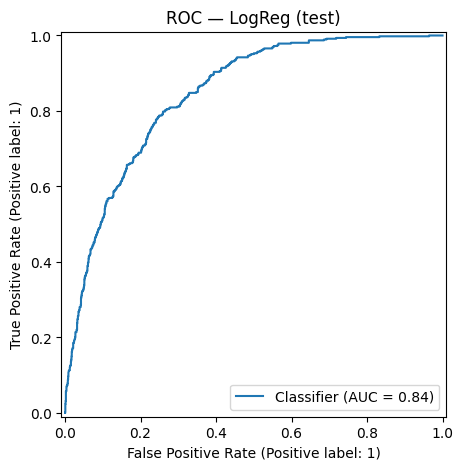

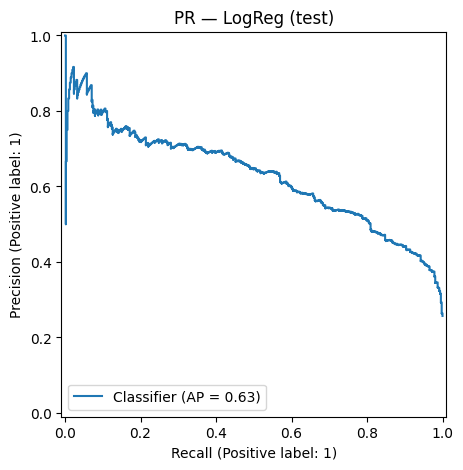

In [10]:
def mean_score(cvres,key):
    return float(np.mean(cvres[f'test_{key}']))

score_lr=mean_score(cv_res_lr,'avg_precision')
score_hgb=mean_score(cv_res_hgb,'avg_precision')

print(f"AvgPrecision CV — LR:  {score_lr:.4f}")
print(f"AvgPrecision CV — HGB: {score_hgb:.4f}")

final_pipe=pipe_hgb if score_hgb>=score_lr else pipe_lr
final_name="HGB" if final_pipe is pipe_hgb else "LogReg"
print("Modelo seleccionado:",final_name)

final_pipe.fit(X_train,y_train)
proba_test=final_pipe.predict_proba(X_test)[:,1]
pred_test=(proba_test>=0.5).astype(int)

print("ROC-AUC (test):",roc_auc_score(y_test,proba_test).round(4))
print("PR-AUC  (test):",average_precision_score(y_test,proba_test).round(4))
print("\nClassification report (thr=0.5):\n",classification_report(y_test,pred_test,digits=4))
print("Confusion matrix:\n",confusion_matrix(y_test,pred_test))

RocCurveDisplay.from_predictions(y_test,proba_test); plt.title(f"ROC — {final_name} (test)"); plt.show()
PrecisionRecallDisplay.from_predictions(y_test,proba_test); plt.title(f"PR — {final_name} (test)"); plt.show()

Mejor umbral por F1 ≈ 0.548 | F1=0.6286, Precision=0.5276, Recall=0.7773

Classification report (umbral óptimo):
               precision    recall  f1-score   support

           0     0.9079    0.7593    0.8269      1350
           1     0.5276    0.7773    0.6286       467

    accuracy                         0.7639      1817
   macro avg     0.7177    0.7683    0.7278      1817
weighted avg     0.8101    0.7639    0.7760      1817



<Figure size 900x500 with 0 Axes>

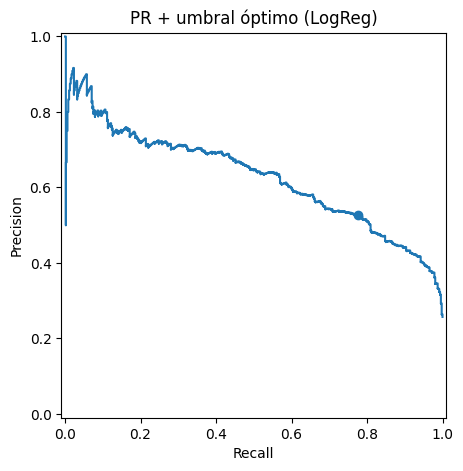

In [11]:
prec,rec,thr=precision_recall_curve(y_test,proba_test)
f1=2*prec*rec/(prec+rec+1e-12)
ix=np.nanargmax(f1)
best_thr=float(thr[ix]) if ix<len(thr) else 0.5

print(f"Mejor umbral por F1 ≈ {best_thr:.3f} | F1={np.nanmax(f1):.4f}, Precision={prec[ix]:.4f}, Recall={rec[ix]:.4f}")

pred_tuned=(proba_test>=best_thr).astype(int)
print("\nClassification report (umbral óptimo):\n",classification_report(y_test,pred_tuned,digits=4))

plt.figure()
PrecisionRecallDisplay(precision=prec,recall=rec).plot()
plt.scatter(rec[ix],prec[ix])
plt.title(f"PR + umbral óptimo ({final_name})"); plt.show()

In [12]:
# Entrena un LR para coeficientes interpretables
pipe_lr_final=Pipeline(steps=[
    ("preprocess",preprocess),
    ("model",LogisticRegression(max_iter=500,class_weight="balanced",random_state=RANDOM_STATE))
]).fit(X_train,y_train)

# Nombres de features post-transformación
final_pipe.named_steps["preprocess"].fit(X_train)
feat_names=get_feature_names(final_pipe.named_steps["preprocess"],num_cols,cat_cols)

# Coeficientes LR
coefs=pipe_lr_final.named_steps["model"].coef_.ravel()
coef_df=pd.DataFrame({"feature":feat_names,"coef":coefs}).sort_values("coef",ascending=False)
display(coef_df.head(15))
display(coef_df.tail(15))

# Importancia por permutación (modelo final)
X_test_processed=final_pipe.named_steps["preprocess"].transform(X_test)
perm=permutation_importance(final_pipe.named_steps["model"],X_test_processed,y_test,
                          n_repeats=10,random_state=RANDOM_STATE,scoring='average_precision')
perm_df=pd.DataFrame({
    "feature":feat_names,
    "importance_mean":perm.importances_mean,
    "importance_std":perm.importances_std
}).sort_values("importance_mean",ascending=False)
display(perm_df.head(20))

,feature,coef
16,internet_InternetService_Fiber optic,0.693615
3,Charges_Total,0.601282
36,account_Contract_Month-to-month,0.591061
32,internet_StreamingTV_Yes,0.258400
35,internet_StreamingMovies_Yes,0.257264
43,account_PaymentMethod_Electronic check,0.248552
27,internet_TechSupport_No,0.162408
18,internet_OnlineSecurity_No,0.140227
14,phone_MultipleLines_Yes,0.121364
40,account_PaperlessBilling_Yes,0.102705


,feature,coef
30,internet_StreamingTV_No,-0.164518
12,phone_MultipleLines_No,-0.181814
44,account_PaymentMethod_Mailed check,-0.204897
34,internet_StreamingMovies_No internet service,-0.278512
28,internet_TechSupport_No internet service,-0.278512
19,internet_OnlineSecurity_No internet service,-0.278512
17,internet_InternetService_No,-0.278512
31,internet_StreamingTV_No internet service,-0.278512
25,internet_DeviceProtection_No internet service,-0.278512
22,internet_OnlineBackup_No internet service,-0.278512


,feature,importance_mean,importance_std
1,customer_tenure,0.259308,0.011620
2,Charges_Monthly,0.074966,0.010974
3,Charges_Total,0.051444,0.011542
16,internet_InternetService_Fiber optic,0.042511,0.010199
15,internet_InternetService_DSL,0.024878,0.010335
36,account_Contract_Month-to-month,0.021001,0.008903
38,account_Contract_Two year,0.013770,0.007187
12,phone_MultipleLines_No,0.008899,0.002271
35,internet_StreamingMovies_Yes,0.007359,0.002047
7,customer_Partner_Yes,0.004814,0.002036


In [13]:
# Guarda pipeline final y métricas
model_path=os.path.join(ARTIFACT_DIR,f"telecomx_model_{final_name}.pkl")
joblib.dump(final_pipe,model_path)
metrics={"model":final_name,
         "roc_auc_test":float(roc_auc_score(y_test,proba_test)),
         "pr_auc_test":float(average_precision_score(y_test,proba_test)),
         "thr_opt_f1":float(best_thr),
         "report_thr_0_5":classification_report(y_test,(proba_test>=0.5).astype(int),digits=4,output_dict=True),
         "report_thr_opt":classification_report(y_test,(proba_test>=best_thr).astype(int),digits=4,output_dict=True)}
with open(os.path.join(ARTIFACT_DIR,"metrics.json"),"w") as f:
    json.dump(metrics,f,indent=2)
perm_out=os.path.join(ARTIFACT_DIR,"permutation_importances.csv")
perm_df.to_csv(perm_out,index=False)

# Informe Markdown
lines=[]
lines.append("# Telecom X — Challenge Parte 2 (Notebook independiente)")
lines.append("\n## 1) Datos y preparación")
lines.append(f"- Fuente: JSON crudo `{JSON_PATH}` (flatten + normalización).")
lines.append(f"- Observaciones: **{len(df):,}**, columnas: **{df.shape[1]}**.")
lines.append("- Limpieza: imputación (mediana/moda), binarios a 0/1, chequeo de cobros.")
lines.append("\n## 2) Correlaciones iniciales")
if not num_corr.empty:
    lines.append("- Top correlaciones numéricas (punto-biserial):\n"+num_corr.head(10).to_markdown(index=False))
if not cat_cramers.empty:
    lines.append("\n- Top asociaciones categóricas (Cramér’s V):\n"+cat_cramers.head(10).to_markdown(index=False))
lines.append("\n## 3) Modelado y evaluación")
lines.append(f"- Seleccionado por PR-AUC (CV): **{final_name}**")
lines.append(f"- ROC-AUC (test): **{metrics['roc_auc_test']:.3f}** | PR-AUC (test): **{metrics['pr_auc_test']:.3f}**")
lines.append(f"- Umbral óptimo por F1: **{metrics['thr_opt_f1']:.3f}**")
lines.append("\n### Reporte (umbral 0.5)\n"+pd.DataFrame(metrics["report_thr_0_5"]).T.round(3).to_markdown())
lines.append("\n### Reporte (umbral óptimo)\n"+pd.DataFrame(metrics["report_thr_opt"]).T.round(3).to_markdown())
lines.append("\n## 4) Importancia de variables")
lines.append("- Coeficientes LogReg (orientan dirección/fuerza):\n"+coef_df.head(10).to_markdown(index=False))
lines.append("\n- Importancia por permutación (modelo final):\n"+perm_df.head(15).to_markdown(index=False))
lines.append("\n## 5) Conclusión estratégica")
lines.append("- Priorizar retención en segmentos de alto riesgo (contratos mes-a-mes, baja antigüedad, etc.).")
lines.append("- Evaluar incentivos a contratos largos, mejoras de soporte y bundles de seguridad.")
lines.append("- Ajustar el umbral de decisión según objetivos de negocio (max recall vs. costo).")
with open(REPORT_PATH,"w",encoding="utf-8") as f:
    f.write("\n".join(lines))

print("Artefactos guardados en:",ARTIFACT_DIR)
print("Modelo:",model_path)
print("PR importances CSV:",perm_out)
print("Reporte Markdown:",REPORT_PATH)

# Vista rápida del reporte
with open(REPORT_PATH,"r",encoding="utf-8") as f:
    print("\n".join(f.read().splitlines()[:60]))

Artefactos guardados en: /content/telecomx_artifacts
Modelo: /content/telecomx_artifacts/telecomx_model_LogReg.pkl
PR importances CSV: /content/telecomx_artifacts/permutation_importances.csv
Reporte Markdown: /content/TelecomX_Part2_Report.md
# Telecom X — Challenge Parte 2 (Notebook independiente)

## 1) Datos y preparación
- Fuente: JSON crudo `/content/TelecomX_Data.json` (flatten + normalización).
- Observaciones: **7,267**, columnas: **21**.
- Limpieza: imputación (mediana/moda), binarios a 0/1, chequeo de cobros.

## 2) Correlaciones iniciales
- Top correlaciones numéricas (punto-biserial):
| feature                |   point_biserial_corr |
|:-----------------------|----------------------:|
| customer_tenure        |             -0.344079 |
| Charges_Total          |             -0.194016 |
| Charges_Monthly        |              0.189866 |
| customer_SeniorCitizen |              0.146733 |

- Top asociaciones categóricas (Cramér’s V):
| feature                   |   cramers_v |
